#                 Simulating a Time of Use Market using OPLEM

- OPLEM is a open source Python package to test and simulate local energy market designs.

- This tutorial presents a demonstration to get you started with the tool

- We will simulate the most basic energy market: A time-of-use market in which each participant in the distribution network optimises its assets in response to the price signals defined by the market.

To simulate a market, 5 steps need to be performed in the given order as shown in the picture below:

1. Load a network: this can be done either by calling a pandas power network or `Network_3ph` of OPLEM.
2. Connect assets: once the netwrok loaded, we will connect assets to each bus in the network. Assets should be created using the `Asset` module.
3. Define participants: Each participant own a group of assets from the assets defined in the previous step. 
4. Setup the market: a market is set up using the `Market` module.
5. Simulation and analysis

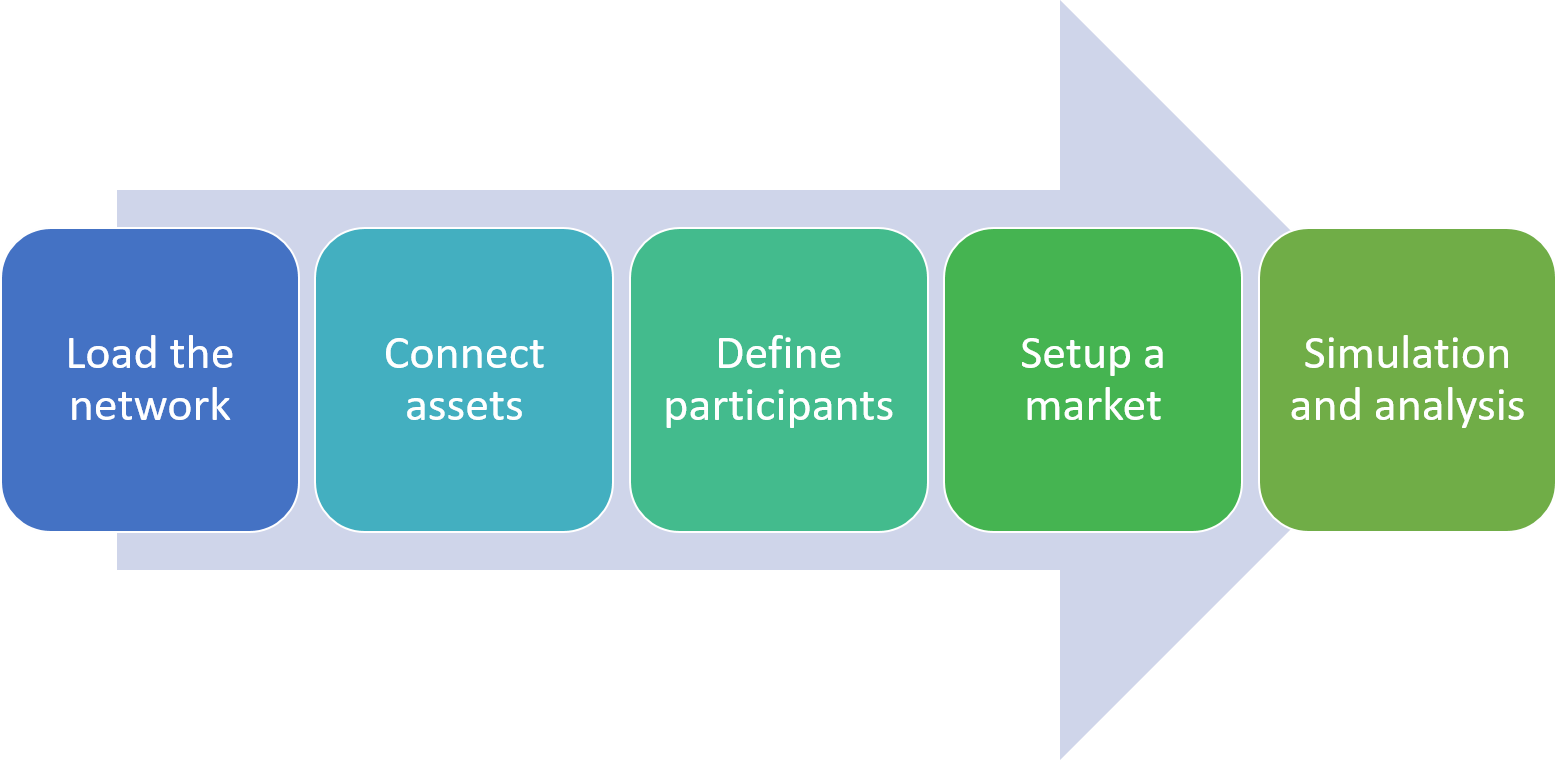


# Step 0: Data preparation and packages loading

## 0.1 Load packages 

In [1]:
#import modules
import os
from os.path import normpath, join
import copy
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

#import OPLEM modules
from oplem.Network_3ph_pf import Network_3ph
import oplem.Assets as AS
import oplem.Participant as Participant
from oplem.Market import ToU_market

# 0.2 Running options

For simplification, we took the control time resolution similar to the optimisation time resolution

In [2]:
np.random.seed(1000)         # fix the seed for reproducible results

dt_raw = 1/60
T_raw = int(24/dt_raw) 

dt = 60/60                   # time intervals for control
T = int(24/dt)               # Number of intervals for control

dt_ems = 60/60               # time intervals for optimisation
T_ems = int(24/dt_ems)       # Number of intervals for optimisation

In [3]:
path_string = normpath('Results\\ToU\\')
if not os.path.isdir(path_string):
    os.makedirs(path_string)

## 0.3 Data

Data can be downloaded from the Data folder under the OPLEM repo to the same directory of the notebook, or the user can use their own data. 

In this example, we will use the data from the OPLEM repo. 

### 0.3.1 Load 

Load data is taken from Customer-Led Network Revolution 

In [10]:
Loads_data_path = os.path.join("Data", "Loads_1min.csv")    
Loads_raw = pd.read_csv(Loads_data_path, index_col=0, parse_dates=True).values
N_loads_raw = Loads_raw.shape[1]
Loads = Loads_raw.transpose().reshape(-1,int(dt/dt_raw)).mean(1).reshape(N_loads_raw,-1).transpose()
Load_ems = Loads.transpose().reshape(-1,int(dt_ems/dt)).mean(1).reshape(N_loads_raw,-1).transpose()

C:\Users\Chaimaa ESSAYEH\AppData\Local\Temp\ipykernel_9036\943611724.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Loads_raw = pd.read_csv(Loads_data_path, index_col=0, parse_dates=True).values


### 0.3.2 PV

PV data is taken from Customer-Led Network Revolution 

In [13]:
PV_data_path = os.path.join("Data", "PV_profiles_norm_1min.txt") 
PVpu_raw = pd.read_csv(PV_data_path, sep='\t').values 
PVpu_raw = PVpu_raw[:,:55]
PVpu_raw = np.vstack((PVpu_raw,np.zeros(55)))
N_pv_raw = PVpu_raw.shape[1]
PVpu = PVpu_raw.transpose().reshape(-1,int(dt/dt_raw)).mean(1).reshape(N_pv_raw,-1).transpose()
PVpu = PVpu[:,0]#taking 1 prof

### Temperature

Taken from [here](https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data?select=temperature.csv)

In [14]:
##winter
Ta_w = np.array([280.65, 280.03,280.16, 279.77, 279.9, 279.65, 279.03, \
                 279.03, 278.52, 278.42, 277.78, 278.4, 278.54, 278.66, 278.54, \
                 278.4, 278.65, 279.27, 280.44, 281.52, 282, 282.89, 283.39, 283.02]) #column C 29/11/2017
Ta_w = np.subtract(Ta_w, 273.15)
##summer
Ta_s = np.array([300.538, 300.538, 300.225, 300.225, 297.63, 297.61, 302.63, 302.61, \
                304.07, 305.07, 306.15, 307.69, 308.86, 309.31, 308.39, 307.4, 303.15,\
                302.15, 300.584, 300.584, 300.483, 300.483, 300.483, 300.31]) # 14/07/2017, column AJ
Ta_s = np.subtract(Ta_s, 273.15)

# Step 1: Setup the network

We will work with the reduced european low voltage EULV network with 55 load buses
![eulv_OPLEM.jpg](eulv_OPLEM1.jpg)

- Colours refer to connected phases, red for Phase A, green for Phase B
and blue for Phase C
- The voltage limits are defined as (0.95, 1.05) p.u and the thermal limits as 2*1e6 p.u (line 5)

In [5]:
network = Network_3ph() 
network.setup_network_eulv_reduced()

# set bus voltage and capacity limits
network.set_pf_limits(0.95*network.Vslack_ph, 1.05*network.Vslack_ph,
                      2000*1e3/network.Vslack_ph)
N_buses = network.N_buses
N_phases = network.N_phases

#buses that contain loads
load_buses = np.where(np.abs(network.bus_df['Pa'])+np.abs(network.bus_df['Pb'])+np.abs(network.bus_df['Pc'])>0)[0]
load_phases = []
N_load_bus_phases=0
for load_bus_idx in range(len(load_buses)):
    phase_list = []
    if np.abs(network.bus_df.iloc[load_buses[load_bus_idx]]['Pa']) > 0:
          phase_list.append(0)
    if np.abs(network.bus_df.iloc[load_buses[load_bus_idx]]['Pb']) > 0:
          phase_list.append(1)
    if np.abs(network.bus_df.iloc[load_buses[load_bus_idx]]['Pc']) > 0:
          phase_list.append(2)
    load_phases.append(np.array(phase_list))  
    N_load_bus_phases += len(phase_list)
    
N_loads = load_buses.size

Updating Y and Z...


# step 2: Connect Assets

We will connect a range of assets to our network: load, curtailable PV, batteries and heat pumps.

## step 2.1 Define parameters

For the study, we will consider:
- PVs with 8 kW power rate
- Batteries with 8 KWh capacity and 4 kW power rating
- Heat pumps with 5.6 kW nominal power, coefficient of performance = 2.5  and temperature comfort between 16 and 18 C

In [49]:
#### 1) Home PV parameters
pv_locs = [0,3,4,6] #locations of PV in the network
Ppv_home_nom = 8 #power rating of the PV generation 

### 2) Home battery parameters
es_locs = [1,3,5,6]
Pbatt_max = 4 #power rate
Ebatt_max = 8 #Capacity
c1_batt_deg = 0.005 #Battery degradation costs

### 3) building parameters
hvac_locs = [2,4,5,6]
Tmax = 18 # degree celsius
Tmin = 16 # degree celsius
T0 = 17 # degree centigrade
#Parameters from 'Aggregate Flexibility of Thermostatically Controlled Loads'
heatmax = 5.6 #kW Max heat supplied
coolmax = 5.6 #kW Max cooling
CoP_heating = 2.5# coefficient of performance - heating
CoP_cooling = 2.5# coefficient of performance - cooling
C = 2 # kWh/ degree celsius
R = 2 #degree celsius/kW

## step 2.2: list of assets per participant

For this simple study, only the first 7 buses will have assets other than the load

Each asset will be linked to a participant after its creation (lines 7, 13, 23, 38)

Here, we consider the assets in the same bus belong to the same participant (homeowner)

In [50]:
N_participants = N_loads
assets_per_participant = [ [] for _ in range(N_participants) ]

## step 2.3: Create the assets

In [51]:
for i in range(N_loads):
    Pnet = Loads[:,i]
    Qnet = Loads[:,i]*0.05
    load_i = AS.NondispatchableAsset(Pnet, Qnet, load_buses[i], dt, T, dt_ems, T_ems, phases=load_phases[i])
    load_i.Pnet_pred = load_i.Pnet
    load_i.Qnet_pred = load_i.Qnet
    assets_per_participant[i].append(load_i)
    
    if i in pv_locs:
        Pnet_pv_i = -PVpu*Ppv_home_nom 
        pv_i = AS.CurtailableAsset(Pnet_pv_i, np.zeros(T_ems), load_buses[i], dt, T, dt_ems, T_ems, phases=load_phases[i], curt=True)
        pv_i.Pnet_pred = pv_i.Pnet
        assets_per_participant[i].append(pv_i)
    
    if i in es_locs:
        Emax_i = Ebatt_max*np.ones(T_ems)
        Emin_i = np.zeros(T_ems)
        ET_i = Ebatt_max*0.5
        E0_i = Ebatt_max*0.5        
        Pmax_i = Pbatt_max*np.ones(T_ems)
        Pmin_i = -Pbatt_max*np.ones(T_ems)
        batt_i = AS.StorageAsset(Emax_i, Emin_i, Pmax_i, Pmin_i, E0_i, ET_i, load_buses[i], dt, T, dt_ems, T_ems, phases=load_phases[i], c_deg_lin = c1_batt_deg)
        assets_per_participant[i].append(batt_i)

    if i in hvac_locs:
        Tmax_bldg_i = Tmax*np.ones(T_ems)
        Tmin_bldg_i = Tmin*np.ones(T_ems)
        Hmax_bldg_i = heatmax
        Cmax_bldg_i = coolmax
        T0_i = T0
        C_i = C
        R_i = R
        CoP_heating_i = CoP_heating
        CoP_cooling_i = CoP_cooling
        Ta_i = Ta_w
        bus_id_bldg_i = load_buses[i]
        bldg_i = AS.BuildingAsset(Tmax_bldg_i, Tmin_bldg_i, Hmax_bldg_i, Cmax_bldg_i, T0_i, C_i, R_i, CoP_heating_i, CoP_cooling_i, Ta_i, bus_id_bldg_i, dt, T, dt_ems, T_ems)
        assets_per_participant[i].append(bldg_i)

# step 3: Define participants

In [52]:
participants = []
for i in range(N_loads):
    #we start id at 1, because 0 is for the slack bus/DSO/upstream
    participant = Participant(i+1, assets_per_participant[i])
    participants.append(participant)

In [53]:
len(participants[0].assets) #[3].type

2

# step 4: Setup the market

## 4.1 setup prices

- Prices follow the UK E7 tariffs

- Feet-in-Tarrif was selected to be lower than the E7 tariffs to consider auto-consumption

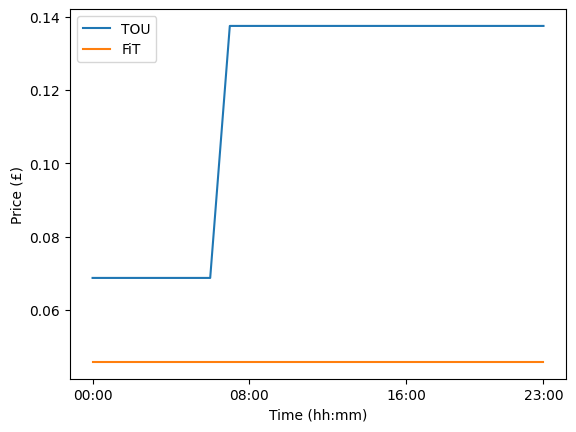

In [17]:
poff, pon = (33/2)/240, 33/240   ##prices from E7 tariff
TOUP = np.append(poff*np.ones(int(7/dt_ems)), pon*np.ones(int(17/dt_ems)))
TOUP = np.expand_dims(TOUP, axis=1)
TOUP = np.repeat(TOUP, network.N_buses, axis=1)

FiT = (pon/3)*np.ones(T_ems)
FiT = np.expand_dims(FiT, axis=1)
FiT = np.repeat(FiT, network.N_buses, axis=1)

plt.figure()
plt.plot(TOUP[:,0], label='TOU')
plt.plot(FiT[:,0], label='FiT')
plt.xlabel('Time (hh:mm)')
plt.xticks([0,8,16,23],('00:00', '08:00', '16:00', '23:00'))
plt.ylabel('Price (£)')
plt.legend()

# 4.2 initialise market

We consider a day-ahead ToU market (t_ahead_0=0)

For intra-day simulations t_ahead_0 should be different than 0.

In [54]:
ToU = ToU_market(participants, dt_ems, T_ems, TOUP, price_exp=FiT, t_ahead_0=0, network=network)

# Step 5: Simulation and Analysis

## 5.1 Market Simulation

In [55]:
## Run market clearing
start_time = time.time() 
mc, schedules = ToU.market_clearing()
elapsed = time.time() - start_time

print('ToU time=' + str(elapsed) + ' sec'  )

print(mc.head())

pickle.dump((mc), open( "Results\\ToU\\mc_simple.p", "wb" ) )
pickle.dump((schedules), open( "Results\\ToU\\schedules_simple.p", "wb" ) )

## Uncomment these lines to store the flexible assets states
"""
Elist, Tinlist = [], []
for p, par in enumerate(participants):
    for a, asset in enumerate(par.assets):
        if isinstance(asset, AS.StorageAsset):
            Elist.append(asset.E_ems)            
        elif isinstance(asset, AS.BuildingAsset): 
            Tinlist.append(asset.Tin_ems)
pickle.dump((Elist), open( "Results\\ToU\\Ebatt_simple.p", "wb" ) )
pickle.dump((Tinlist), open( "Results\\ToU\\Tin_simple.p", "wb" ) )
"""

Run EMS for Participant: 1
* Updating resources for participant 1...
* Adding  participant 1 trades to clearing outcome...
Run EMS for Participant: 2
* Updating resources for participant 2...
* Adding  participant 2 trades to clearing outcome...
Run EMS for Participant: 3
* Updating resources for participant 3...
* Adding  participant 3 trades to clearing outcome...
Run EMS for Participant: 4
* Updating resources for participant 4...
* Adding  participant 4 trades to clearing outcome...
Run EMS for Participant: 5
* Updating resources for participant 5...
* Adding  participant 5 trades to clearing outcome...
Run EMS for Participant: 6
* Updating resources for participant 6...
* Adding  participant 6 trades to clearing outcome...
Run EMS for Participant: 7
* Updating resources for participant 7...
* Adding  participant 7 trades to clearing outcome...
Run EMS for Participant: 8
* Updating resources for participant 8...
* Adding  participant 8 trades to clearing outcome...
Run EMS for Part

'\nElist, Tinlist = [], []\nfor p, par in enumerate(participants):\n    for a, asset in enumerate(par.assets):\n        if isinstance(asset, AS.StorageAsset):\n            Elist.append(asset.E_ems)            \n        elif isinstance(asset, AS.BuildingAsset): \n            Tinlist.append(asset.Tin_ems)\npickle.dump((Elist), open( "Results\\ToU\\Ebatt_simple.p", "wb" ) )\npickle.dump((Tinlist), open( "Results\\ToU\\Tin_simple.p", "wb" ) )\n'

## 5.2 Network Simulation

In [56]:
network_pf = ToU.simulate_network_3ph()
pickle.dump((network_pf), open( "Results\\ToU\\nw_pf_simple.p", "wb" ) )

## 5.3 Analysis

### 5.3.1 Schedules per participant

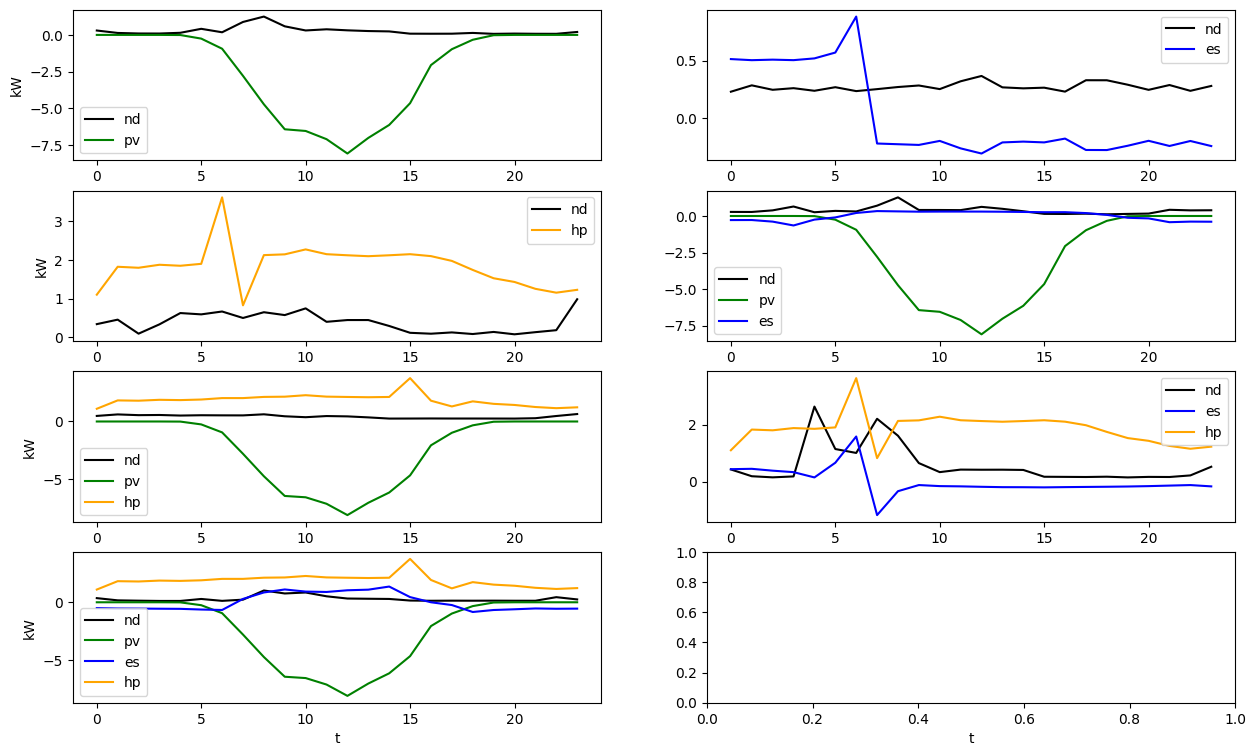

In [57]:
#lables
assets = [['nd', 'pv'], ['nd', 'es'], ['nd', 'hp'], ['nd', 'pv', 'es'], ['nd', 'pv', 'hp'], ['nd', 'es', 'hp'], 
          ['nd', 'pv', 'es', 'hp']]

#colors for labels
colors={'nd': 'black',
        'pv': 'green',
        'hp': 'orange',
        'es': 'blue'}

### uncomment these if the results are stored
#schedules = pd.read_pickle('Results\\ToU\\schedules_simple.p')
#market_clearing = pd.read_pickle('Results\\ToU\\mc_simple.p')
    
####### schedules per participant
fig, axs = plt.subplots(4,2, figsize=(15,9))
## plot the results for the first 7 participant who have assets other than the load
for par in range(7):
    schedule = schedules[par]
    for a in range(len(schedule)):
        axs[int(par/2)][par%2].plot(schedule[a], label=assets[par][a], color=colors[assets[par][a]])
        axs[int(par/2)][par%2].legend()
    axs[int(par/2)][0].set_ylabel('kW')
    axs[-1][par%2].set_xlabel('t')
#plt.savefig('TOUP_schedules.jpg')

### 5.3.2 Assets' States

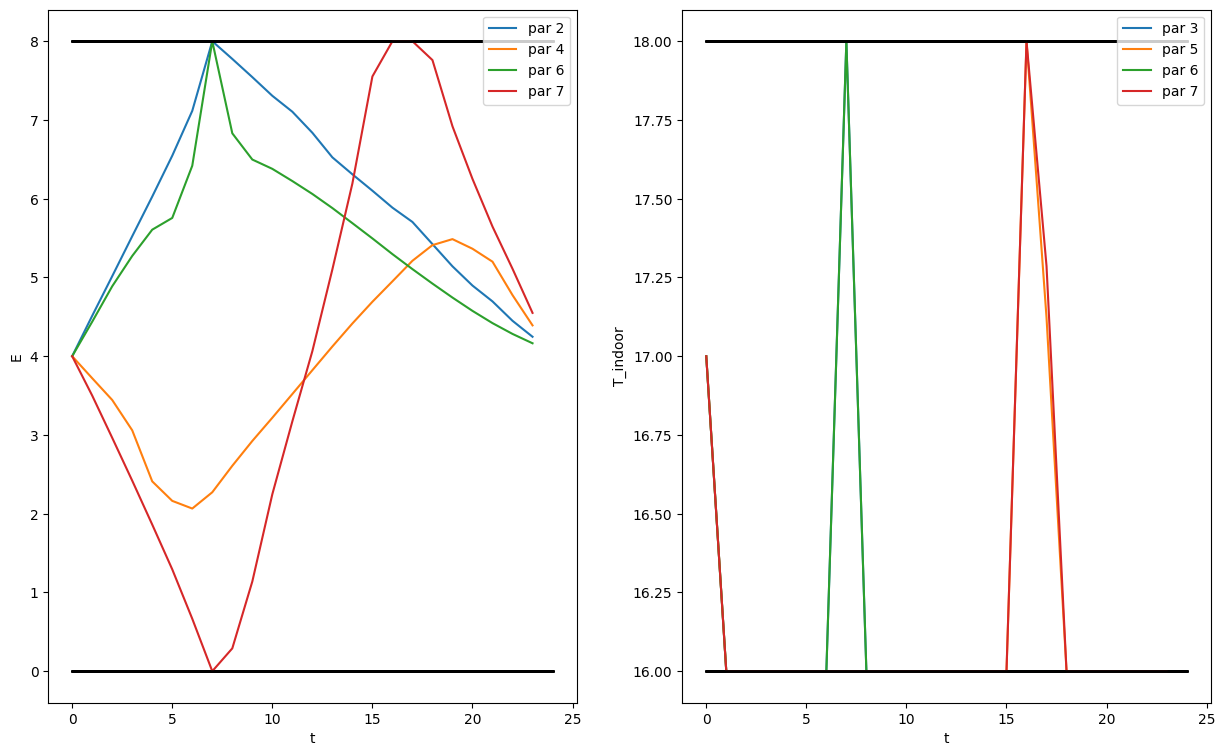

In [58]:
fig, axs = plt.subplots(1,2, figsize=(15,9))
for p, par in enumerate(participants):
    for a, asset in enumerate(par.assets):
        if isinstance(asset, AS.StorageAsset): #assets[par][a] == 'es':
            axs[0].plot(asset.E_ems, label='par {}'.format(p+1))
            axs[0].hlines(y=8, xmin=0, xmax=24, linewidth=2, color='black')
            axs[0].hlines(y=0, xmin=0, xmax=24, linewidth=2, color='black')
            axs[0].set_xlabel('t')
            axs[0].set_ylabel('E')
            axs[0].legend()
            
        elif isinstance(asset, AS.BuildingAsset): #assets[par][a] == 'hp':
            axs[1].plot(asset.Tin_ems, label='par {}'.format(p+1))
            axs[1].set_xlabel('t')
            axs[1].set_ylabel('T_indoor')
            axs[1].hlines(y=16, xmin=0, xmax=24, linewidth=2, color='black')
            axs[1].hlines(y=18, xmin=0, xmax=24, linewidth=2, color='black')
            axs[1].legend()  
#plt.savefig('TOUP_states.jpg')

### 5.3.3 Exchanges and Revenues

Here, we focus on the exchange between the DSO and the downstream network as a whole. 

A more refined analysis can be done by zooming in on each participant since _mc_ dataframe stores the energy exchanges in detail

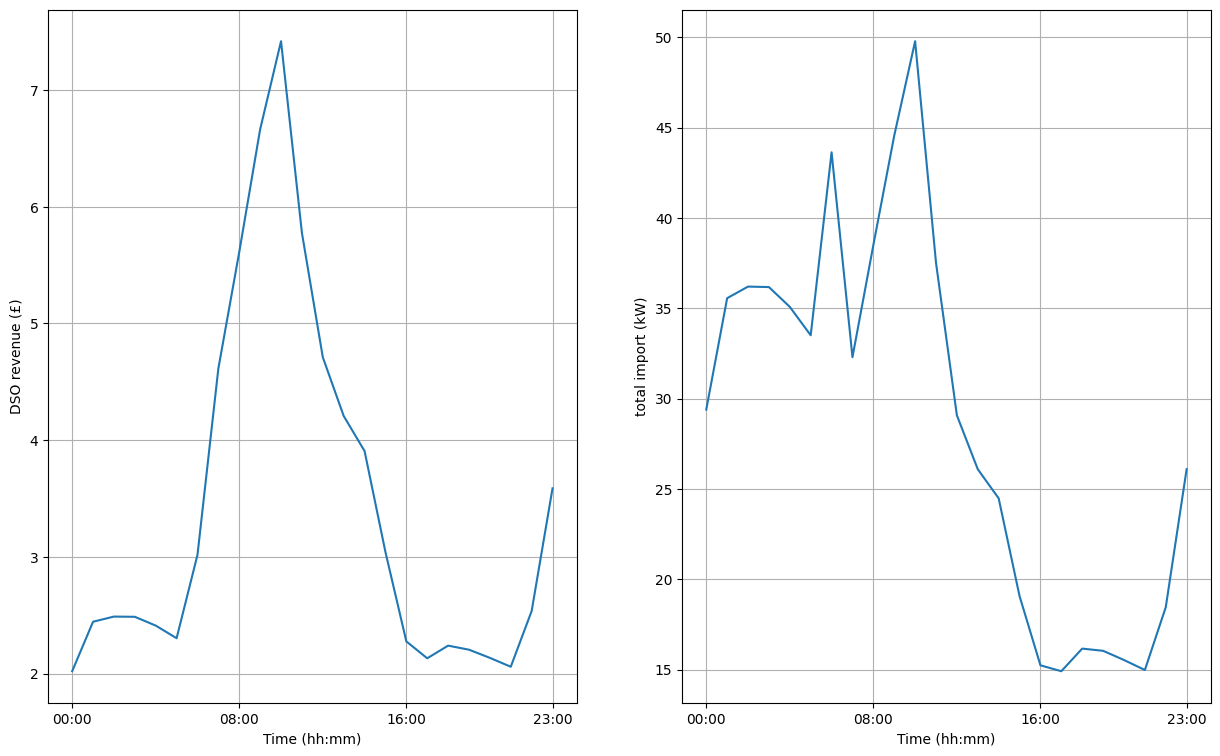

In [59]:
#mc =pd.read_pickle(""Results\\ToU\\mc_simple.p")

revenue_tou, total_tou =np.zeros(T_ems), np.zeros(T_ems)

for t in range(T_ems):
    pimp = np.asarray(mc[(mc['seller']==0) & (mc['time']==t)]['price'])
    pexp = np.asarray(mc[(mc['buyer']==0) & (mc['time']==t)]['price'])
    
    import_tou = np.asarray(mc[(mc['seller']==0) & (mc['time']==t)]['energy'])
    export_tou = np.asarray(mc[(mc['buyer']==0) & (mc['time']==t)]['energy'])
    
    total_tou[t] = np.sum(import_tou) - np.sum(export_tou)
    revenue_tou[t] = np.sum(pimp*import_tou) - np.sum(pexp*export_tou) 
    
fig, axs = plt.subplots(1,2, figsize=(15,9))
axs[0].plot(revenue_tou)
axs[0].set_xlabel('Time (hh:mm)')
axs[0].set_xticks([0,8,16,23],('00:00', '08:00', '16:00', '23:00'))
axs[0].set_ylabel('DSO revenue (£)')
#axs[0].legend()
axs[0].grid()
####
axs[1].plot(total_tou)
axs[1].set_xlabel('Time (hh:mm)')
axs[1].set_xticks([0,8,16,23],('00:00', '08:00', '16:00', '23:00'))
axs[1].set_ylabel('total import (kW)')
#axs[1].legend()
axs[1].grid()
#####

### 5.2.4 Voltages

Text(0, 0.5, 'voltage (p.u)')

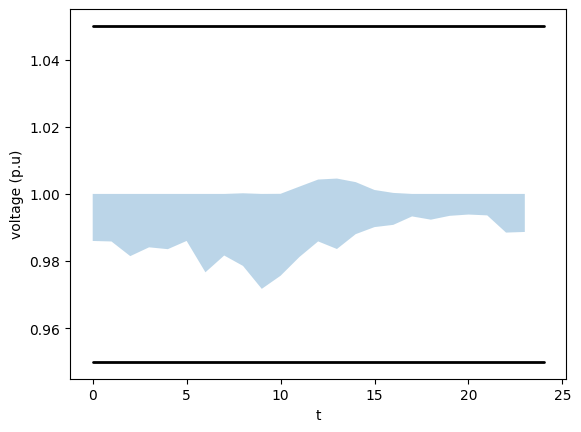

In [60]:
#netwrok_pf =pd.read_pickle(""Results\\ToU\\nw_pf_simple.p")

voltage = np.zeros((T_ems, 2)) # 1 column to store the min voltage per time slot 
                               # and the other for the max voltage in the network

for t, network_sim in enumerate(network_pf):
    buses_Vpu = np.abs(network_sim.v_net_res)/network_sim.Vslack_ph  
    vn =min(filter(lambda x: x != 0, buses_Vpu))
    voltage[t, 0] = vn
    voltage[t, 1] = np.max(buses_Vpu)
    
    if np.max(buses_Vpu)>1.05:
        print('for t ={}, Vmax={} at index: {}'.format(t, np.max(buses_Vpu), np.argmax(buses_Vpu)))
    elif vn<0.95:
        ind = np.where(buses_Vpu==vn)
        print('for t ={}, Vmin={} at index: {}'.format(t, vn, ind))

plt.figure()       
plt.fill_between(np.arange(24), voltage[:,0], voltage[:,1], alpha=.3) #color='b', 
plt.hlines(y=1.05, xmin=0, xmax=24, linewidth=2, color='black')
plt.hlines(y=0.95, xmin=0, xmax=24, linewidth=2, color='black')
plt.xlabel('t')
plt.ylabel('voltage (p.u)')
#plt.savefig('TOUP_voltages.jpg')